## Эксперимент SSA на синтетическом sin

Метод проведения эксперимента:

1.   Генерация выборки зашумленного синуса.

2.   Создание подвыборки

3.   Оптимизация w модели

4.   Сохранение w

5.   Пункты 1-3 много (K) раз

6. Оценка cov, E

Здесь восстанавливается ВЕСЬ временной ряд

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [3]:
!pip install geotorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 KB 2.0 MB/s eta 0:00:00


Генерируем зашусленный sin

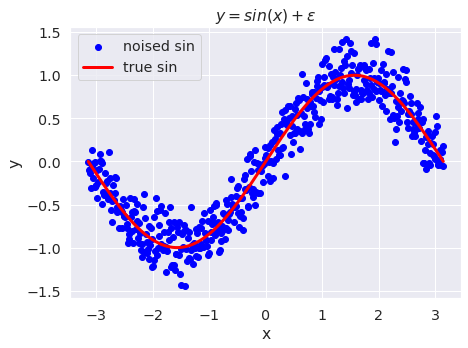

In [9]:
from drive.MyDrive.metric_analysis.modules.classes_and_functions import generate_noised_sin
from drive.MyDrive.metric_analysis.modules.ssa_functions import *
from collections import defaultdict
from tqdm import tqdm_notebook
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# генерация выборки
sample_size = 500
noise_std = 0.2 # интенсивность шума
window_scale = 1

window_size = 1 # размер окна для Ганкеля

X, y_true, y = generate_noised_sin(sample_size, window_scale=window_scale, noise_std=noise_std, visualize=True)

Восстанавливаем временной ряд с помощью SSA алгоритма для различных значений количества слагаемых в сингулярном разложении, $k$, и размера окна для матрицы Ганкеля $emb\_size$

In [11]:
losses_y = defaultdict(lambda: defaultdict(lambda: dict(mse=[], mape=[]))) # k, emb_size -> mse, mape losses
losses_y_true = defaultdict(lambda: defaultdict(lambda: dict(mse=[], mape=[]))) # k, emb_size -> mse, mape losses


for emb_size in tqdm_notebook(range(1, len(y) + 1, 10)):
    try:
        y_h = create_hankel_matrix(y, emb_size=emb_size, step_size=1)
    except:
        break

    y_s, eign_vectors, eign_values = get_eigenvalues_and_vectors(y_h)

    for k in range(1, len(y_s) + 1, 10):
        y_recovered = flatten_time_serie(group_by_eign_incr_and_hank(y_s, eign_values, k))

        losses_y[emb_size][k]['mse'].append(mse_loss(y, y_recovered))
        losses_y[emb_size][k]['mape'].append(mape_loss(y, y_recovered))

        losses_y_true[emb_size][k]['mse'].append(mse_loss(y_recovered, y_true))
        losses_y_true[emb_size][k]['mape'].append(mape_loss(y_recovered, y_true))

<ipython-input-11-d3a8322a0217>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for emb_size in tqdm_notebook(range(1, len(y) + 1, 10)):


  0%|          | 0/50 [00:00<?, ?it/s]

MSE между восстановленным рядом и зашусленным

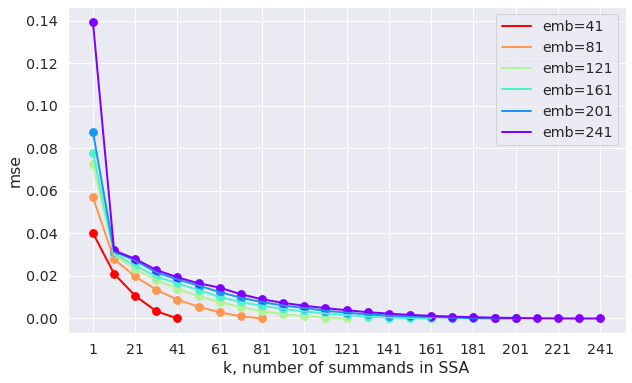

In [15]:
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y[emb_size][k]['mape'])
        mses.append(losses_y[emb_size][k]['mse'])
    #print(k_s)
    plt.plot(k_s, mses, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mses, color=c, marker='o', s=60)


plt.xlabel('k, number of summands in SSA')
plt.ylabel('mse')
plt.xticks(k_s[::2])
#plt.hlines(0.1, 0, 250)

plt.legend();

MSE между восстановленным рядом и истинным

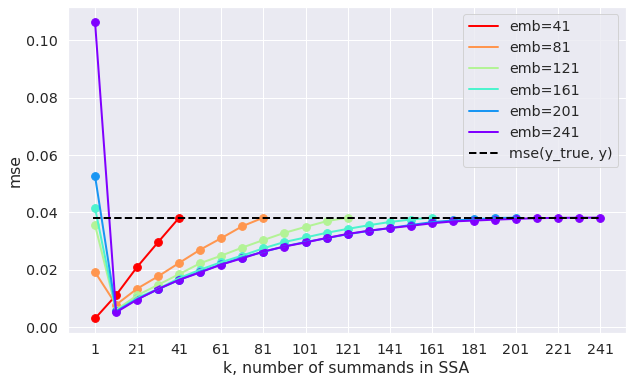

In [16]:
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y_true.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y_true.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y_true[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y_true[emb_size][k]['mape'])
        mses.append(losses_y_true[emb_size][k]['mse'])
    #print(k_s)
    plt.plot(k_s, mses, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mses, color=c, marker='o', s=60)


plt.xlabel('k, number of summands in SSA')
plt.ylabel('mse')
plt.xticks(k_s[::2])
plt.hlines(mse_loss(y_true, y), 0, 241, color='black', linestyle='--', linewidth=2, label='mse(y_true, y)')

#plt.title('MSE of recovery - MSE of approximation')

plt.legend();

MAPE между восстановленным рядом и зашумленным

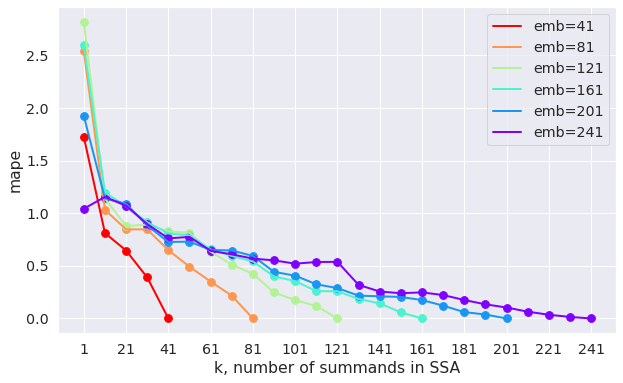

In [17]:
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y[emb_size][k]['mape'])
        mses.append(losses_y[emb_size][k]['mse'])
    #print(k_s)
    plt.plot(k_s, mapes, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mapes, color=c, marker='o', s=60)

plt.xlabel('k, number of summands in SSA')
plt.ylabel('mape')
plt.xticks(k_s[::2])
#plt.hlines(0.1, 0, 250)

plt.legend();

MAPE между восстановленным рядом и истинным

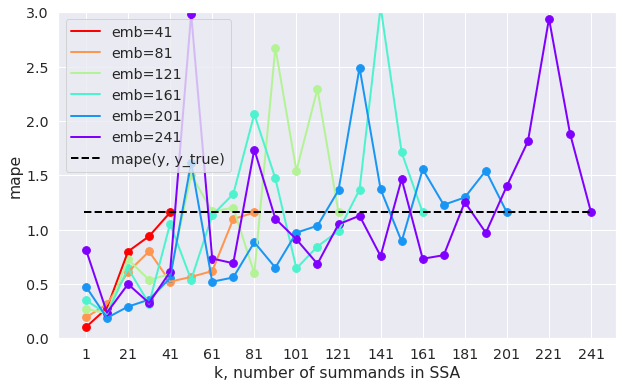

In [18]:
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(list(losses_y_true.keys())[4::4])))

for c, emb_size in zip(colors[::-1], list(losses_y_true.keys())[4::4]):
    k_s = []
    mapes = []
    mses = []

    for k in losses_y_true[emb_size].keys():
        k_s.append(k)
        mapes.append(losses_y_true[emb_size][k]['mape'])
        mses.append(losses_y_true[emb_size][k]['mse'])
    #print(k_s)
    # print(mapes)
    plt.plot(k_s, mapes, linewidth=2, label=f'emb={emb_size}', color=c)
    plt.scatter(k_s, mapes, color=c, marker='o', s=60)

plt.xlabel('k, number of summands in SSA')
plt.ylabel('mape')
plt.xticks(k_s[::2])
plt.hlines(mape_loss(y, y_true), 0, 241, color='black', linestyle='--', linewidth=2, label='mape(y, y_true)')
plt.ylim(0, 3)
plt.legend();